In [1]:
import sys, os
import torch
import pandas as pd
import glob
from tqdm import tqdm
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np


local_user_path = '/home/jq01/git/cleo_jason_working_branch' # change to your own path
sys.path.append(local_user_path) 
from ensemble import Ensemble
from data_util import FragmentDataset

### load model and check prediction accuracy

In [2]:
ls /home/jq01/git/cleo_jason_working_branch/data/super/

241204_super_random_purified_data.csv  super_fragment_data.csv
241217_super_pool_and_evaluated.csv


In [40]:
## yaml file
# checkpoint path
## checkpoint prefix : last.ckpt
## dataset path
## fragment path 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check if gpu is available
print(f"Using device: {device}")

# path to the checkpoint directory 
base_path = '/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_fragment_wo_val_run1/241217_train_final_fragment_wo_val_run1.2024-12-17-13-09-20'

# load checkpoint
ckpt_name = 'last.ckpt'
ckpt = torch.load(os.path.join(base_path,ckpt_name), map_location=torch.device('cpu'))
config = OmegaConf.load(os.path.join(base_path,'config.yaml'))

# load model
model = Ensemble(config)
model.load_state_dict(ckpt['state_dict'])
model = model.to(device)

# load fragments dataframe
config.data.dataset_cfg.fragment_csv = f'{local_user_path}/data/super/super_fragment_data.csv'

# load full 324k super dataset
dataset_path = f'{local_user_path}/data/super/241217_super_pool_and_evaluated.csv' # full dataset
data = pd.read_csv(dataset_path)
data=data.sample(5000)

dataset = FragmentDataset(config.data.dataset_cfg, data)

# run through the dataset
mu = [] # mean of the ensemble models
sigma = [] # standard deviation of the ensemble models
ubc = []  # upper bound confidence bound of the ensemble models
# pred_mean = []   # mean of the individual models in the ensemble 
# pred_var = []    # standard deviation of the individual models in the ensemble 

for i in tqdm(range(len(dataset))):
    x, y = dataset[i] #  x has the input features, y is the output label  
    x = x.to(device)    # move x to the gpu. y is not moved to the gpu because it is not used in the forward pass.

    with torch.no_grad(): # not checking gradient during the operation. For the notebook add thisline but for the standalon script it is not necessary, which case delete it and de-indent the next line
        output = model(x[None])
        output = {k: v.cpu() for k, v in output.items()}
        mu.append(output["mu"].item())
        sigma.append(output["sigma"].item())
        ubc.append(output["mu"].item()+output["sigma"].item())
        # pred_mean.append(torch.flatten(output["mean"]).tolist())
        # pred_var.append(torch.flatten(output["var"]).tolist())

data['mu_pred'] = mu     # predicted mean from the model
data['sigma_pred'] = sigma   # predicted standard deviation from the model
data['ubc_pred'] = ubc    # predicted upper bound confidence from the model

data

# save csv file full_pool_evalution and saving it into the checkpoint path... 

Using device: cpu


/tmp/ipykernel_173340/3447908803.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(base_path,ckpt_name), map_location=torch.device('cpu'))


,name,sequence,raw_rate,cluster_id,cluster_size,has_been_evaluated,z_score_norm_rate,min_max_norm_rate,mu_pred,sigma_pred,ubc_pred
17917,frag1_temp0.5num103COMBO:frag2_temp0.2num106:f...,TEDDRRVATVLAATRAIAREVAQDYKDAFLQAFEARDGAALRRVIT...,-inf,bc01dad0,20,False,-inf,-inf,-0.492542,0.393554,-0.098987
251167,frag1_temp0.5num124COMBO:frag2_temp0.2num106:f...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVIT...,-inf,2974d8c1,28,False,-inf,-inf,-0.699075,0.325912,-0.373164
163604,frag1_parent_1:frag2_temp0.2num021COMBO:frag3_...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVLT...,-inf,943609fb,4889,False,-inf,-inf,0.222675,0.588254,0.810929
6057,frag1_temp0.5num103COMBO:frag2_temp0.5num115CO...,TEDDRRVATVLAATRAIAREVAQDYKDAFLQAFEARDGAALRRVLT...,-inf,4d46d962,28,False,-inf,-inf,-0.679588,0.372225,-0.307363
161026,frag1_parent_1:frag2_temp0.2num102:frag3_temp0...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,-inf,7b0d40c2,33,False,-inf,-inf,0.201911,0.555067,0.756977
...,...,...,...,...,...,...,...,...,...,...,...
91317,frag1_temp0.2num054COMBO:frag2_temp0.5num019:f...,SEDDVLVEKVLKATEEIAKEKAEAYKDAFLAAYNARDGAGLRRVIT...,-inf,cb388081,25,False,-inf,-inf,0.066334,0.625951,0.692285
281382,frag1_temp0.2num078COMBO:frag2_temp0.2num082:f...,SPEQERVDAILAATRKIAKEVAVGFEDAFLRAYRARDGAALRRVIT...,-inf,1d1325ea,4804,False,-inf,-inf,0.836758,0.746764,1.583522
48053,frag1_temp0.5num115:frag2_temp0.2num055:frag3_...,SDDQVRVEDVLRATREIAKEVGQSFQAAFAEAYDARDGAALRRVIT...,-inf,16af1806,27718,False,-inf,-inf,0.906136,0.765764,1.671900
244200,frag1_temp0.5num090:frag2_temp0.2num028:frag3_...,SPEDARVARVLAATREIARREAEGFREDFLRAYAARDGAALRRVIT...,-inf,13389289,2762,False,-inf,-inf,0.803239,0.756126,1.559365


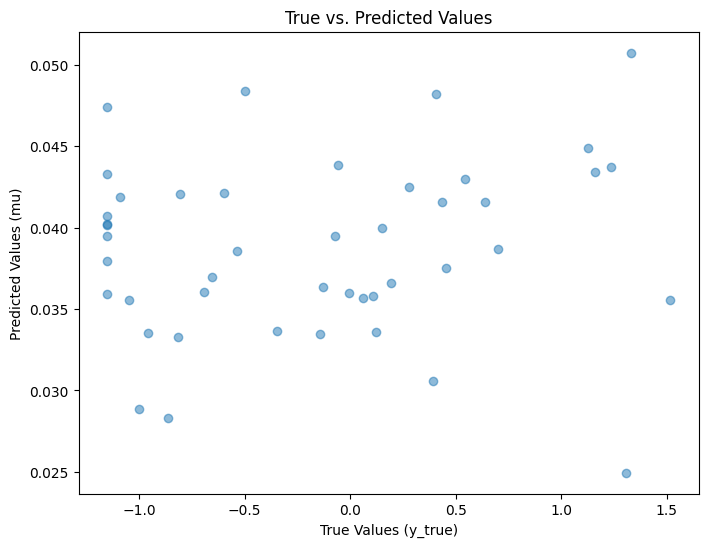

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, mu, alpha=0.5)
#plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Identity line
plt.xlabel("True Values (y_true)")
plt.ylabel("Predicted Values (mu)")
plt.title("True vs. Predicted Values")
plt.show()

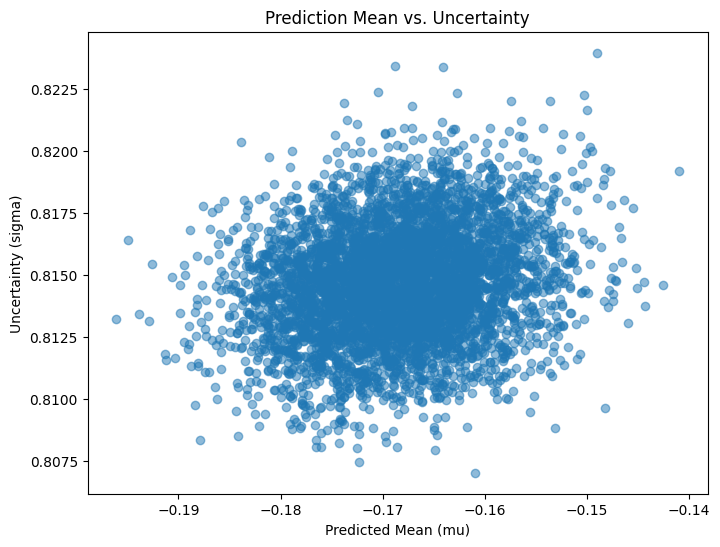

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(mu, sigma, alpha=0.5)
plt.xlabel("Predicted Mean (mu)")
plt.ylabel("Uncertainty (sigma)")
plt.title("Prediction Mean vs. Uncertainty")
plt.show()

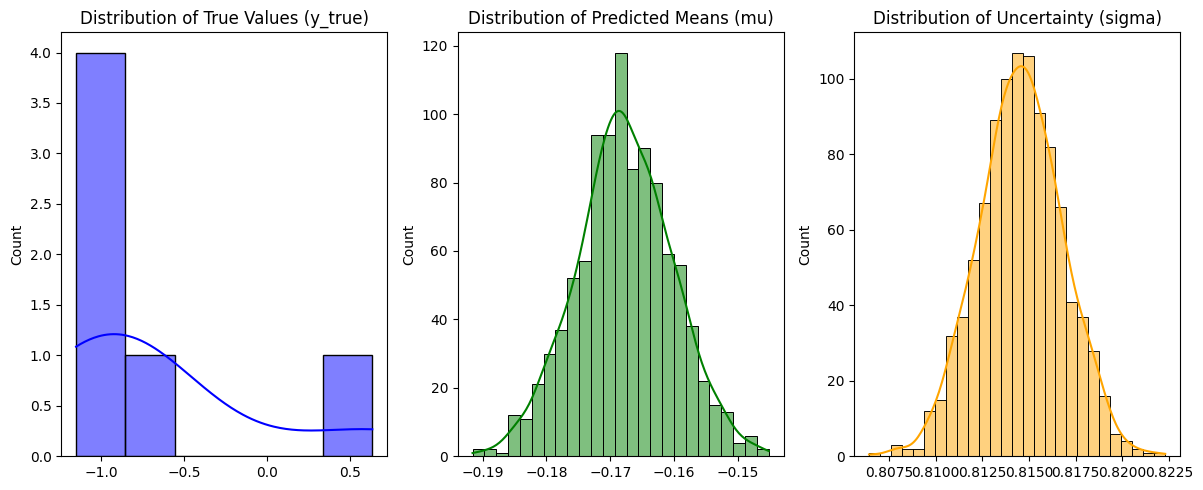

In [39]:
import seaborn as sns

plt.figure(figsize=(12, 5))

# True values distribution
plt.subplot(1, 3, 1)
sns.histplot(y_true, kde=True, color="blue")
plt.title("Distribution of True Values (y_true)")

# Predicted mean distribution
plt.subplot(1, 3, 2)
sns.histplot(mu, kde=True, color="green")
plt.title("Distribution of Predicted Means (mu)")

# Uncertainty distribution
plt.subplot(1, 3, 3)
sns.histplot(sigma, kde=True, color="orange")
plt.title("Distribution of Uncertainty (sigma)")

plt.tight_layout()
plt.show()

In [6]:
corr, _ = stats.pearsonr(y_true, mu)

plt.figure(dpi=100)
plt.scatter(x=y_true, y=mu,alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('pred fitness')
plt.title(f'pearsonr {corr:.2f}')
plt.xlim([-3,15])
plt.ylim([-3,15])

plt.show()

/home/jq01/.conda/envs/cleo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4787: RuntimeWarning: invalid value encountered in subtract
  xm = x.astype(dtype) - xmean


ValueError: array must not contain infs or NaNs

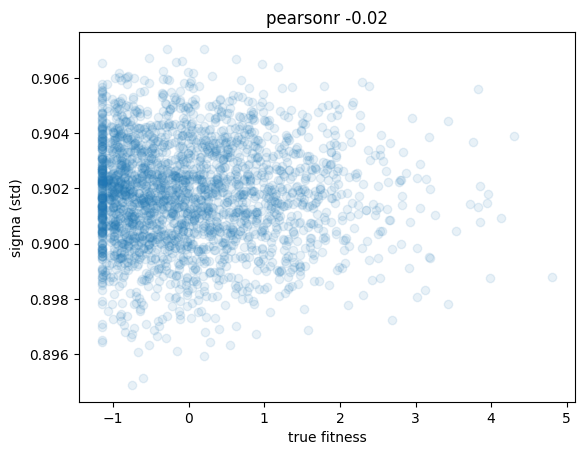

In [45]:
plt.figure(dpi=100)
corr, _ = stats.pearsonr(y_true, sigma)

plt.scatter(x=y_true, y=sigma, alpha=0.1)
plt.xlabel('true fitness')
plt.ylabel('sigma (std)')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

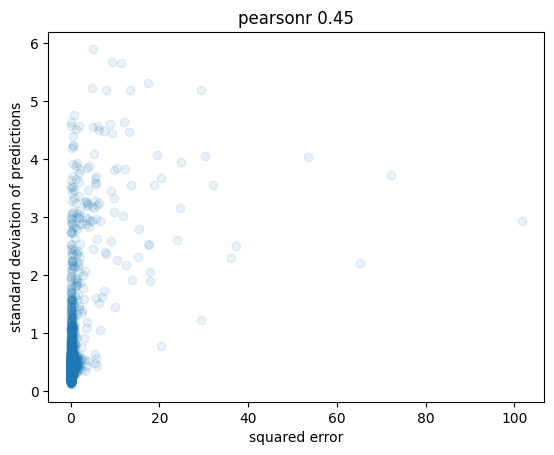

In [8]:
se = ((torch.tensor(y_true) - torch.tensor(mu))**2).tolist()
var = [x**2 for x in sigma]
corr, _ = stats.pearsonr(se, sigma)
plt.figure(dpi=100)
plt.scatter(x=se, y=sigma, alpha=0.1)
plt.xlabel('squared error')
plt.ylabel('standard deviation of predictions')
plt.title(f'pearsonr {corr:.2f}')
plt.show()

### checking to see if uncertainty correlates with distance from train set


In [165]:
train_data = data[~data['val']]
full_dataset = '/home/jgershon/git/cleo/data/four-site_clean_simplified_AA_data.csv'
full_data = pd.read_csv(full_dataset)

train_seqs = train_data['AAs'].tolist()
mean_dists = []
min_dists = []
for i,r in tqdm(full_data.iterrows()):
    val_seq = r['AAs']
    dists = []
    for train_seq in train_seqs:
        dist = sum([a!=b for a,b in zip(val_seq,train_seq)])
        dists.append(dist)

    min_dists.append(min(dists))
    mean_dists.append(torch.tensor(dists).float().mean().item())

full_data['min_dist'] = min_dists
full_data['mean_dist'] = mean_dists

159129it [07:44, 342.30it/s]


In [172]:
dataset = FragmentDataset(full_data,
                config.data.input_col,
                config.data.label_col,
                config.data.name_col,
                fragment_csv,
                config.data.use_fragment_representation,)

# run through the dataset
y_true = []
mu = []
sigma = []
pred_mean = []
pred_var = []

for x, y in tqdm(dataset):
    
    with torch.no_grad():
        
        output = model(x[None])
        mu.append(output["mu"].item())
        sigma.append(output["sigma"].item())
        pred_mean.append(output["mean"])
        pred_var.append(output["var"])
        y_true.append(y.item())

100%|██████████| 159129/159129 [09:03<00:00, 292.77it/s]


Text(0, 0.5, 'standard deviation of ensemble')

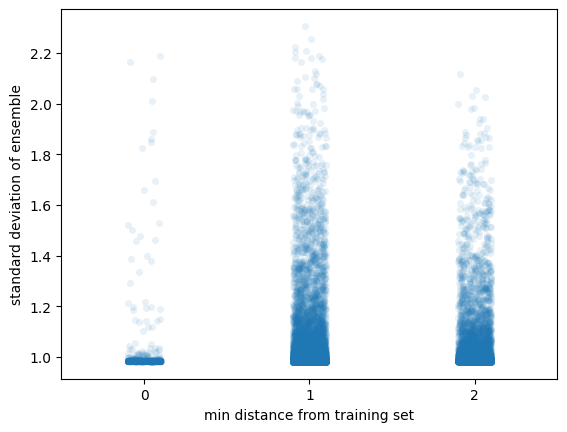

In [173]:
full_data['sigma'] = sigma

sns.stripplot(data=full_data, x='min_dist', y='sigma',alpha=0.1)
plt.xlabel('min distance from training set')
plt.ylabel('standard deviation of ensemble')